## Introduction

In the last section, we took a look at the pyplot interface, and covered just about everything you'll need to explore your data using the matplotlib library. While the pyplot interface is the most common way that you’ll interact with matplotlib on a day-to-day basis, from time-to-time you’ll find it’s necessary to drop down into the lower levels of the matplotlib stack, and at that point, it’s useful to know a bit about the architecture of the library.

In this section, we’ll "pop the hood" and take a look at how the matplotlib library works. Starting with this lesson, we’ll get an overview of the library's architecture and we'll see a small example of the Object-Oriented API in action. Then, in the next lesson, we’ll take a deeper look at the components of a typical matplotlib figure.  Finally, we’ll loop back to the pyplot interface once again, and use everything we’ve just learned to understand what our pyplot-based scripts are doing “underneath the hood."

### The [not so normal] Setup

Now, this is normally the part where I would say something like "let's go ahead and run the normal setup code for our notebook", but in this lesson we'll be doing things a bit differently. The code below is our normal setup code, but with one minor difference: we're not importing the `pyplot` interface for this notebook, and that's because in this lesson, we'll be bypassing the `pyplot` interface and instead going straight to the Object-Oriented API to create our simple example visualization. So, for this lesson, let's go ahead and run our slightly abnormal setup code.

In [1]:
%matplotlib inline

import numpy as np 

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Overview

One of the core architectural ideas behind matplotlib is that there should be a definite separation of concerns. In other words, the part of the framework responsible for creating and manipulating a "figure" should be completely segregated from the portion of the framework responsible for rendering that figure. This allows backends to be added and removed as necessary without any changes to the interface the user sees, and sophisticated behaviors can be added to the scripting interface without affecting the backend rendering at all.

To accomplish this architectural goal, the framework is divided up into three distinct layers: the scripting layer, the artist layer, and the backend layer. Within this stack, each layer knows only of the existence of the one below it, while the the layer below is not aware of the one above. This effectively decouples the layers to some extent, and helps the library achieve its goal of separating the creation of figures from their rendering.

And, now that we have an overview of the matplotlib architecture, let's take a look at each layer of the stack in a bit more detail, starting from the bottom.

## The Backend Layer

The first layer in the stack is the backend layer, and it’s responsible for interacting with the UI (e.g., GTK, wxPython, and QT), and creating hardcopy representations (e.g., PDF, PNG, and SVG). With respect to the UI, it's also responsible for handling events, such as key presses, button presses, mouse movements, and so forth. 

The backend layer has three abstract base classes that it provides concrete interfaces for:

- FigureCanvas - encapsulates the concept of a surface on which to draw (i.e., "the paper").
- Renderer - does the drawing (i.e., "the paintbrush").
- Event - handles inputs such as keyboard and mouse events.

The analogy that we'll be using throughout this lesson to explain the interaction between the classes in the different layers is that of an artist creating a painting. With this analogy in mind, the `FigureCanvas` class can be seen as the painter's canvas. This is where the artist will create their masterpiece, i.e., your visualization. The `Renderer` then, would be the paintbrush. The `Renderer` is mainly responsible for providing a low-level drawing interface. So, for example, `Renderer` instances provide methods such as `draw_path` and `draw_image`. The artist then uses these methods to "paint" a figure onto a canvas.

## The Artist Layer

The Artist layer is the middle layer between the backend and scripting layers and is responsible for the creation of a Figure. This layer is where you'll create your plots by slapping together several `Artist` objects to create a single `Figure`, which itself is an `Artist` as well.

To continue with the painting analogy, an `Artist` uses a `Renderer` (a paintbrush) to add paint to paper (i.e., to draw a `Figure` onto a `FigureCanvas`). Everything in a matplotlib `Figure` is an `Artist`, and there are two types of artists objects: primitive artists, that represent the kinds of objects you see in a plot (e.g., `Line2D`, `Rectangle`, `Text`), and composite artists, that are collections of `Artist` objects (e.g., `Figure`, `Axes`, `Axis`).

The most important composite artist, and arguably artist in general, is the `Axes` class, which is where most of the plotting methods are defined. Not only does the `Axes` contain most of the graphical elements that make up the background of the plot---the ticks, the axis lines, the grid, the patch of color that makes up the background---it also provides numerous helper methods that can be used to create primitive artists and add them to an `Axes` instance.

At this point, it's a good time to talk about the Object-Oriented API and to give an example of how it's used. 

### The Object-Oriented API

The Object-Oriented API is simply a mixture of classes from both the Artist and Backend layers. To be perfectly frank, calling this interface the Object-Oriented API is a bit of a misnomer, since `pyplot` is also itself just as Object-Oriented. With each call that you make to the `pyplot` module, the interface either creates, or manages an instance of a class from the Object-Oriented API. The difference then, is that the `pyplot` module hides all of this complexity behaind a stateful, procedural interface, whereas the Object-Oriented API hides nothing, and therefore gives the user more power.

To really get a feel for how the Object-Oriented API works, and demistify it, and the `pyplot` interface a bit, we'll create a simple visualization using just the classes from the Artist and Backend layers.

The example in this section was taken from the [matplotlib][1] chapter of the [Architecture of Open Source: Volume II][2] book by John Hunter, matplotlib's creator, and Michael Droettboom, one of matplotlib's lead developers. In this example, we will create a histogram from some randomly generated data using matplotlib's Object-Oriented API. Since we'll only be using the lower two layers of the matplotlib architectural stack, we won't need to import the `pyplot` module. Instead, we'll import the `Figure` class from the Artist layer, and the `FigureCanvasAgg` class from the Backend layer. 

> If you're curious, the 'Agg' in the `FigureCanvasAgg` class is short for [Anti-Grain Geometry][3] which is a high-quality, high-performance library for rendering 2-dimensional, anti-aliased graphics, like PNG's for instance. We'll use it here as the hardcopy representation for our graphic.

[1]: http://www.aosabook.org/en/matplotlib.html
[2]: http://www.aosabook.org/en/index.html
[3]: https://en.wikipedia.org/wiki/Anti-Grain_Geometry

In [2]:
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure 

Once we have everything imported, we'll need to create instances of the `Figure` and `FigureCanvasAgg` classes. For the latter, we'll need to pass in an instance of the `Figure` class.

Now, astute readers will remember that earlier I mentioned that each layer in the matplotlib stack knows about the layer beneath it, but not the other way around. But, of course, giving an instance of the `Figure` class, a class from the Artist layer, to the `FigureCanvasAgg` instance, a class from the Backend layer, seems to break this requirement. And, you would be right. 

On the whole, the lower layers know next to nothing about the higher layers, but in this one instance, that division is broken a bit, and the lower level is coupled with the upper level ever so slightly. The reason for doing this, is that the canvas object is responsible for calling the `draw` method on the `Figure` instance to start the rendering process. This makes sense since the backend layer is responsible for interacting with the UI, it only makes sense that it would also be responsible for initiating the rendering process, say for example, once a user clicks a button, or presses a specific key.

In [3]:
# Create a Figure and a Canvas object
fig = Figure() 
canvas = FigureCanvasAgg(fig) 

The next bit should look pretty familiar by now. We're simply using the NumPy library to generate a random sampling of $10,000$ data points from the normal distribution that we'll use to create our histogram.

In [4]:
# Use NumPy to create some random data
x = np.random.randn(10000) 

Then, we'll use that data to create the histogram.

Now, this bit should look pretty familiar as well. We're simply creating a new subplot, plotting a histogram of our data, and adding a title. These are all tasks that we've performed before in the section on the `pyplot` interface. The only difference between what we've seen before and the code below, is that we're doing everything with methods on the `Figure` and `Axes` instances that we've created, rather than calling a function from the `pyplot` module.

In [5]:
# Create an Axes object by calling the add_subplot method
# on the Figure object. 
ax = fig.add_subplot(111)

# Then call its hist method to plot the data as a histogram. 
ax.hist(x, 100) 

# Finally, add a title to the plot. On a side note, the 
# majority, if not all, of the plotting functions reside
# in the Axes object.
ax.set_title('Normal distribution with $\mu=0, \sigma=1$');

Finally, we'll display the histogram, and we'll do so by calling the `display_png` function that the `IPython` library provides. We could also just "return" the figure as well, in which case, IPython would cycle through a list of supported formats until it finds one that works with the `Figure` object. Peronsonally, I like calling the `display_png` function, however, simply because it seems slightly less magical.

Now, when we display our figure, the canvas object will first create a new `Renderer` instance using the boundary information that it gets from the `Figure` object that was passed in. Then it will call the `draw` method on the `Figure` object and pass in the `Renderer` object. Inside the Figure's `draw` method is where the real coupling between the two layers exists. In this method, the `Artist` object will call several methods on the `Renderer` object that was passed in, and so it must have an intimate knowledge of the interface that the `Renderer` provides.

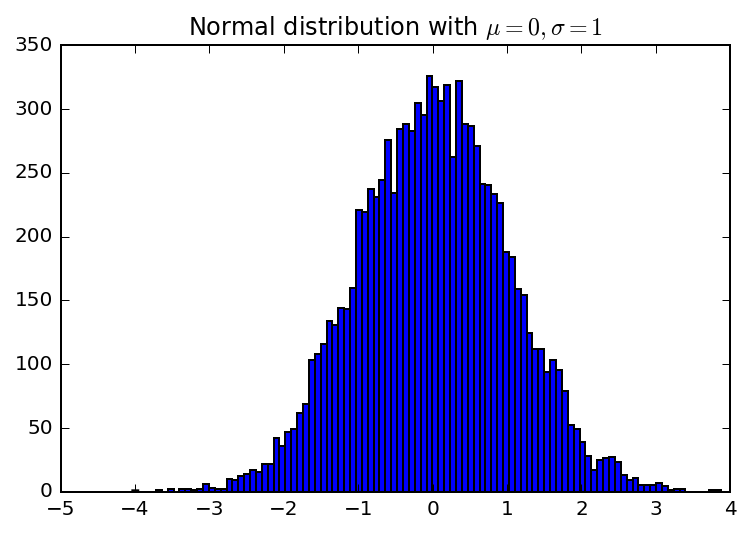

In [6]:
# Show the figure.
from IPython.display import display_png
display_png(fig)

## The Scripting Layer

And, that will bring us to the last layer of the stack, the Scripting layer. 

Now, matplotlib's Object-Oriented API is useful when creating a GUI application, or a bunch of visualizations at a time, or a backend server for a web application, but when you're doing a simple, one-off exploration of some data, you want something a bit lighter weight, and that's exactly what the Scripting Layer offers. If this sounds at all familiar to you, it's because another name of the Scripting Layer is the `pyplot` interface. And, since we're all already intimately familiar with this interface, I believe we can call this lesson complete.

## Conclusion

To recap, in this lesson, we got a crash course on the architecture of the matplotlib library. We discussed some of the reasons behind the choices that were made, and we also saw an example of creating a simple visualization using nothing more than classes from the lower two layers, also known as the Object-Oriented API. In the next lesson, we'll dig into the Artist layer further by taking a closer look at the classes that make up a matplotlib `Figure`.